In [144]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from main_funcs import get_and_update_data

In [145]:
# configs
country=None
joft = "BTCUSDT"
interval = "1d"

# remove small candle 
zero_remover_pct = 0.0

# add history of open_close_pct 
open_close_pct_history_count = 5

# add history of max_low_high_pct 
max_low_high_pct_history_count = -1

# calculate rsi with different lengths 
rsi_ranges = range(14, 20)

# add history of rsi
rsi_history_count = -1

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [146]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [147]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [148]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

In [149]:
# create calculate target
df_target = df_cal.copy()
mabna = 'open_close_pct'

# calculate target
# df_target["target"] = df_target[mabna]
df_target["target"] = np.where(
    df_target[mabna] > zero_remover_pct,
    df_target[mabna],
    np.where(
        df_target[mabna] < -zero_remover_pct,
        df_target[mabna], None
    )
)

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [150]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)


df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,target
open_time,,,,,,,
2017-08-22 03:30:00,0.005976,-0.013057,-0.008418,0.007694,-0.041238,0.005538,0.018319
2017-08-23 03:30:00,0.018319,0.005976,-0.013057,-0.008418,0.007694,-0.041238,0.040755
2017-08-24 03:30:00,0.040755,0.018319,0.005976,-0.013057,-0.008418,0.007694,-0.008186
2017-08-25 03:30:00,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.008418,0.013252
2017-08-26 03:30:00,0.013252,-0.008186,0.040755,0.018319,0.005976,-0.013057,-0.005193
...,...,...,...,...,...,...,...
2023-11-10 03:30:00,0.016363,0.030214,0.006373,0.010073,0.000977,-0.001431,-0.004601
2023-11-11 03:30:00,-0.004601,0.016363,0.030214,0.006373,0.010073,0.000977,-0.001774
2023-11-12 03:30:00,-0.001774,-0.004601,0.016363,0.030214,0.006373,0.010073,-0.016221


In [151]:
# analyse df
print("shape df: ", df.shape)
df.corr()['target'].sort_values(ascending=False)

shape df:  (2276, 7)


target               1.000000
open_close_pct__1    0.043061
open_close_pct__4    0.026288
open_close_pct__5    0.018249
open_close_pct__2    0.007873
open_close_pct__3    0.005480
open_close_pct__0   -0.046086
Name: target, dtype: float64

In [152]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xg_reg = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, verbosity=3)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

[15:35:09] ======== Monitor (0): HostSketchContainer ========
[15:35:09] AllReduce: 0.00014s, 1 calls @ 140us

[15:35:09] MakeCuts: 0.000172s, 1 calls @ 172us

[15:35:09] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[15:35:10] ======== Monitor (0): Learner ========
[15:35:10] Configure: 0.000232s, 1 calls @ 232us

[15:35:10] EvalOneIter: 0.002227s, 1000 calls @ 2227us

[15:35:10] GetGradient: 0.005203s, 1000 calls @ 5203us

[15:35:10] PredictRaw: 0.000395s, 1000 calls @ 395us

[15:35:10] UpdateOneIter: 0.240513s, 1000 calls @ 240513us

[15:35:10] ======== Monitor (0): GBTree ========
[15:35:10] BoostNewTrees: 0.232773s, 1000 calls @ 232773us

[15:35:10] CommitModel: 0.000179s, 1000 calls @ 179us

[15:35:10] ======== Monitor (0): HistUpdater ========
[15:35:10] BuildHistogram: 0.048592s, 2730 calls @ 48592us

[15:35:10] EvaluateSplits: 0.077318s, 3730 calls @ 77318us


In [154]:
metrics.mean_absolute_error(y_test, y_pred)

0.030604369733992068

In [155]:
metrics.r2_score(y_test, y_pred)

-0.12566451112183086

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

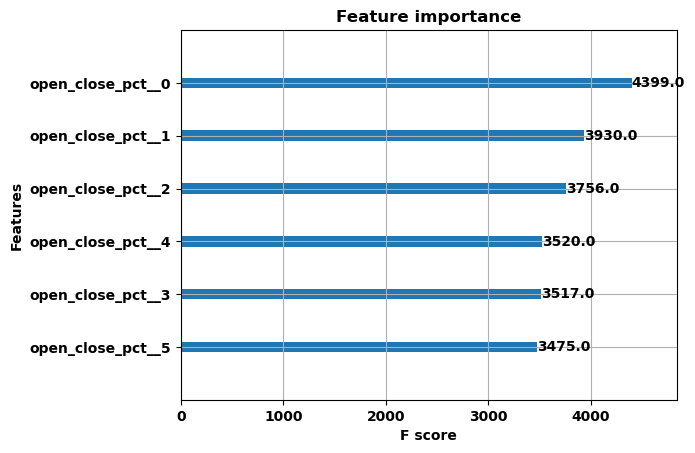

In [156]:
xgb.plot_importance(xg_reg, max_num_features=10)